In [90]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew
import feature_process_helper as fp
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

## Lasso 1

### load data

In [91]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [92]:
train, test = fp.mssubclass(train, test)
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute(train, test)
train, test = fp.scale(train, test)
train, test = fp.dummies(train, test)

0.775806224312 seconds


### find optimal value of the Lasso alpha parameter

In [93]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Lasso

alpha_ridge = [10, 20, 30, 40, 50]

coeffs = {}
z = 1.01
for alpha in alpha_ridge:
    r = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
    r = r.fit(train, y)
    coeffs[str(z)+':'+str(alpha)] = np.append(r.score(train, y), np.append(r.intercept_, r.coef_))
    z += .01
    
grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)
grid_search.fit(train, y)

print grid_search.best_estimator_
print grid_search.score(train, y)

Lasso(alpha=40, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
0.884810357837


### inspect results

In [94]:
a = pd.DataFrame(coeffs).transpose()
columns = ['SCORE', 'INTERCEPT']+list(train.columns)
dict = {}
i = 0 
for c in columns:
    dict[i] = c
    i += 1
a.rename(columns = dict, inplace=True)
a

,SCORE,INTERCEPT,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family
1.01:10,0.906304,-359993.222673,-1122.756308,3654.279782,8470.834862,4629.287437,169.625163,53.201734,3273.654289,1926.747567,...,0.0,7957.921244,0.0,26102.174410,4985.049002,-6359.145133,0.0,0.0,7476.195193,-3038.878548
1.02:20,0.898402,-506952.906273,-0.000000,3000.613166,9254.420112,4285.713011,194.874230,70.794516,2615.415683,2296.354317,...,0.0,0.000000,0.0,20777.545869,0.000000,-5294.360250,0.0,-0.0,2153.758763,-1443.378045
1.03:30,0.891721,-521054.936396,-0.000000,2848.362989,10239.964851,3863.648048,197.905237,83.006815,2202.593985,2451.743806,...,0.0,0.000000,0.0,12578.858589,0.000000,-4493.565826,0.0,-0.0,0.000000,-0.000000
1.04:40,0.884810,-521680.564655,-0.000000,2744.919852,11119.319966,3363.147814,198.331603,99.756336,1902.662206,2645.859346,...,0.0,0.000000,0.0,3219.990762,0.000000,-3659.204473,0.0,-0.0,0.000000,-0.000000
1.05:50,0.878126,-524298.146483,0.000000,2678.808468,11885.404231,2917.920732,189.388979,109.267016,1723.804829,2788.017583,...,0.0,0.000000,-0.0,0.000000,0.000000,-2706.007992,0.0,-0.0,0.000000,-0.000000


### fit lasso model with optimal alpha

In [ ]:
lasso = Lasso(alpha=40, normalize=True, max_iter=1e5)
lasso = lasso.fit(train, y)

### last-second check that our test dataset doesn't contain empty columns

In [ ]:
for i in test.columns:
    if sum(pd.isnull(test[i])) > 0:
        print i, sum(pd.isnull(test[i]))

### predict test data and create submission file

In [ ]:
lasso.predict(test)

In [ ]:
predictions = lasso.predict(test)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lasso1.csv'), sep=",", index = False)

score: .013624

## Linear Regression 1

### load data

In [43]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [44]:
train, test = fp.mssubclass(train, test)
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute(train, test)
train, test = fp.scale(train, test)
train, test = fp.dummies(train, test)

1.25477410561 seconds


### find optimal value of the Lasso alpha parameter

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Lasso

alpha_ridge = [10, 20, 30, 40, 50]

coeffs = {}
z = 1.01
for alpha in alpha_ridge:
    r = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
    r = r.fit(train, y)
    coeffs[str(z)+':'+str(alpha)] = np.append(r.score(train, y), np.append(r.intercept_, r.coef_))
    z += .01
    
grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)
grid_search.fit(train, y)

print grid_search.best_estimator_
print grid_search.score(train, y)

In [45]:
coeffs = {}
z = 1.01
alpha = 40
r = Lasso(alpha, normalize=True, max_iter=1e5)
r = r.fit(train, y)
coeffs[str(z)+':'+str(alpha)] = np.append(r.score(train, y), np.append(r.intercept_, r.coef_))
z += .01

In [46]:
lasso = pd.DataFrame([np.array(train.columns), coeffs['1.01:40'][2:]]).transpose()

In [47]:
lasso_clean = lasso[lasso[1] != 0][0]

In [48]:
len(lasso_clean)

62

In [49]:
train = train[lasso_clean]
test = test[lasso_clean]

### use select K best to further narrow down number or columns

In [64]:
# Create SelectKBest() Object
kbest = SelectKBest()
lm = linear_model.LinearRegression()

# Create the Pipeline() obejct, and then fit it against the data set. 
pipeline = Pipeline([('kbest', kbest),
                     ('lm', lm)])

In [65]:
# Create a grid_search_dict. Using these with a pipeline can be a little tricky - note that
#    you have to specify which pipeline component you want to grid search by using the alias
#    you provided when you created the Pipeline object + '__' + [argument name]. 
grid_search_dict = {'kbest__k': range(1, len(train.columns)+1)}     

grid_search = GridSearchCV(pipeline, param_grid=grid_search_dict, cv=3, n_jobs=-1)
grid_search.fit(train, y)

# Let's see how our SelectKBest/GridSearch classifier performed
#print 'SelectKBest/GridSearch - Accuracy: ', grid_search.score(y, grid_search.predict(train))

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x000000000AA61588>)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [66]:
print grid_search.best_params_
print grid_search.best_score_

{'kbest__k': 59}
0.842104691208


In [67]:
grid_search.best_estimator_

Pipeline(steps=[('kbest', SelectKBest(k=59, score_func=<function f_classif at 0x000000000AA61588>)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

### inspect results

In [68]:
grid_search = grid_search.best_estimator_
grid_search.fit(train, y)

# Let's see how our SelectKBest/GridSearch classifier performed
print 'SelectKBest/GridSearch - Accuracy: ', grid_search.score(train, y)

SelectKBest/GridSearch - Accuracy:  0.896459555554


### predict test data and create submission file

In [69]:
predictions = grid_search.predict(test)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lm1.csv'), sep=",", index = False)

score: 0.15001

## Linear Regression 2

### load data

In [80]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [81]:
train, test = fp.mssubclass(train, test)
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute(train, test)
train, test = fp.dummies(train, test)

0.712638614368 seconds


### use select K best to further narrow down number or columns

In [82]:
# Create SelectKBest() Object
kbest = SelectKBest()
lm = linear_model.LinearRegression()

# Create the Pipeline() obejct, and then fit it against the data set. 
pipeline = Pipeline([('kbest', kbest),
                     ('lm', lm)])

In [83]:
# Create a grid_search_dict. Using these with a pipeline can be a little tricky - note that
#    you have to specify which pipeline component you want to grid search by using the alias
#    you provided when you created the Pipeline object + '__' + [argument name]. 
grid_search_dict = {'kbest__k': range(1, len(train.columns)+1)}     

grid_search = GridSearchCV(pipeline, param_grid=grid_search_dict, cv=3, n_jobs=-1)
grid_search.fit(train, y)

# Let's see how our SelectKBest/GridSearch classifier performed
#print 'SelectKBest/GridSearch - Accuracy: ', grid_search.score(y, grid_search.predict(train))

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x000000000AA61588>)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, ...226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [84]:
print grid_search.best_params_
print grid_search.best_score_

{'kbest__k': 198}
0.819652594611


In [85]:
grid_search.best_estimator_

Pipeline(steps=[('kbest', SelectKBest(k=198, score_func=<function f_classif at 0x000000000AA61588>)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

### inspect results

In [86]:
grid_search = grid_search.best_estimator_
grid_search.fit(train, y)

# Let's see how our SelectKBest/GridSearch classifier performed
print 'SelectKBest/GridSearch - Accuracy: ', grid_search.score(train, y)

SelectKBest/GridSearch - Accuracy:  0.909055724318


### predict test data and create submission file

In [87]:
predictions = grid_search.predict(test)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lm2.csv'), sep=",", index = False)

score: ERROR - one of the predictions was negative

## Lasso 2

### load data

In [138]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [139]:
train, test = fp.mssubclass(train, test)

In [140]:
def log(train, test, y):
    for i in (train, test):
		#log transform skewed numeric features:
		numeric_feats = train.dtypes[train.dtypes != "object"].index

		skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
		skewed_feats = skewed_feats[skewed_feats > 0.75]
		skewed_feats = skewed_feats.index

		i[skewed_feats] = np.log1p(i[skewed_feats])

    y = np.log1p(y)
    return train, test, y

In [141]:
train, test, y = log(train, test, y)

In [142]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute(train, test)
#train, test = fp.scale(train, test)
train, test = fp.dummies(train, test)

0.814447119588 seconds


### find optimal value of the Lasso alpha parameter

In [69]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [71]:
alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas]

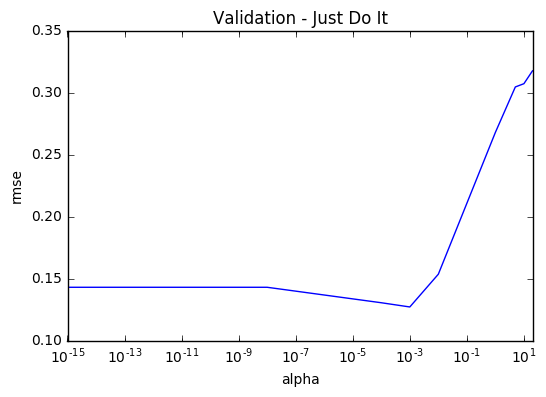

In [73]:
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Just Do It", logx=True)
plt.xlabel("alpha")
plt.ylabel("rmse")

In [102]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Lasso

alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

coeffs = {}
for alpha in alpha_ridge:
    r = Lasso(alpha=alpha, normalize=True, max_iter=1000000)
    r = r.fit(train, y)
    
grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), scoring='neg_mean_squared_error',
                           param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)
grid_search.fit(train, y)

print grid_search.best_estimator_
print grid_search.score(train, y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
-0.0115547775381


### inspect results

#### how do different values of alpha compare to the rmse?

In [107]:
alpha = []
rmse = []
for i in range(0, len(grid_search.grid_scores_)):
    alpha.append(grid_search.grid_scores_[i][0]['alpha'])
    rmse.append(np.sqrt(-grid_search.grid_scores_[i][1]))

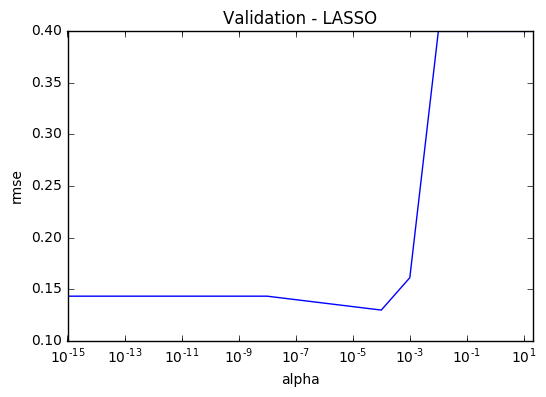

In [112]:
lasso_cv = pd.Series(rmse, index = alpha)
lasso_cv.plot(title = "Validation - LASSO", logx=True)
plt.xlabel("alpha")
plt.ylabel("rmse")

### fit lasso model with optimal alpha

In [113]:
lasso = Lasso(alpha=.0001, normalize=True, max_iter=1e6)
lasso = lasso.fit(train, y)

### inspect variable importance

In [114]:
coef = pd.Series(lasso.coef_, index = train.columns)

In [115]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 106 variables and eliminated the other 139 variables


In [116]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

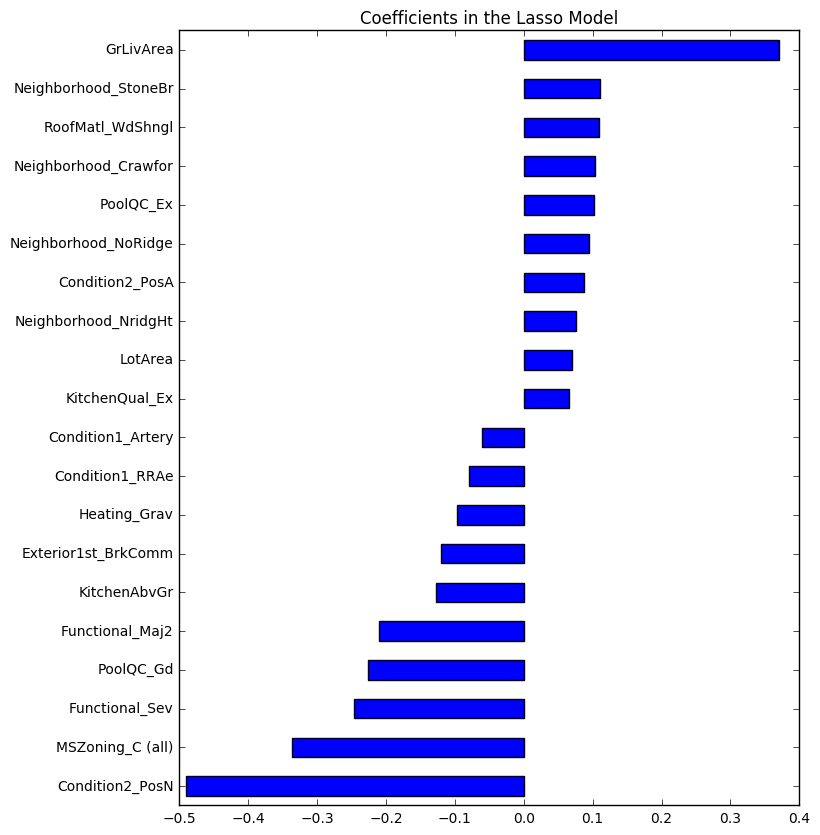

In [118]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### predict test data and create submission file

In [147]:
lasso.predict(test)

array([ 1221.55523466,  1603.98721768,  1652.92183456, ...,  1958.90067664,
        1170.53081799,  1502.99464261])

In [159]:
predictions = lasso.predict(test)/100
predictions = np.expm1(predictions)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lasso2.csv'), sep=",", index = False)

score: .013624